# Computational Methods in Simulation (CMIS) Week 4
This notebook is intended to help students make their hand-in in this week of CMIS.

Hand-ins must be submitted as a maximum 5 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 19 - follow the detailed steps below to learn about the finite element method:

* 1D Poisson Problem
    * Make an implementation of the 1D example. Use the values $x_1 = 1$, $x_n = 2$, $\Delta x = 0.1$, $a = 1$, $b = 2$, $c = 0$.
    * Start by making a sketch on paper showing how you expect $y(x)$ to look like.
    * Discuss which parts of the algorithm that is embarrassingly parallel. 
    * If you have extra time consider rewriting the parts that have race conditions to become embarrassingly parallel.
    * Consider using an iterative method (like Conjugate Gradient) for solving the reduced system, can you suggest any optimizations? (Hint: do not actually assemble the global matrix)


* 2D Poisson Problem
    * Derive the formula for $K_e$ and $f_e$ in full detail for the 2D example.
    * Make an implementation of the 2D example on a rectangular domain that is 6-by-2 in size.
    * Set $a = 1$ on the left edge of the rectangle and $a = 2$ on the right size.
    * Use $c = 0$
    * Treat boundary conditions as point wise conditions
    * Discuss from a computer scientist viewpoint which steps are the same and which steps that are different compared to the 1D example.

## Detailed Expected Learning Objectives in this Week

* Finite Element Method (FEM) Part 1 (Slides 19)
    * Explain the steps of the FEM method.
    * Account for terminology such as test and shape/basis functions.
    * Explain the consequence of changing grid spacing, especially from linear to non-linear grid spacing, within the FEM method and why one would choose on eor the other
    * Apply the steps of FEM method from simple 1D and/or 2D problems like Heat diffusion.
    * Apply experimental verification to ones implementation of a FEM.

In [20]:
%matplotlib widget

In [21]:
# import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt

# The 1D Poisson Problem solved with Linear Finite Element Method

We first compute an array Ke of local elementwise values. Aftewards we assemble the local values into a global martix and vector. First we ignore boundary conditions and simply just fill in values. We expect to have one-zero eigenvalue of this type of problem as we have not yet added boundary conditions. Due to precision and round-off errors the numerical computed eigenvalues may not be exactly zero but close to machine epsilon.

In [22]:
dx = 0.1
x  = np.linspace(1.0, 2.0, 10)
N  = len(x)
Ke = np.zeros((2,(N-1)*2),dtype=np.float64)  
K  = np.zeros((N,N),dtype=np.float64)
f  = np.zeros((N,),dtype=np.float64)


for e in range(N-1):
    i = e
    j = i+1
    Ke[0,2*e+0] = 1.0/dx
    Ke[0,2*e+1] = -1.0/dx
    Ke[1,2*e+0] = -1.0/dx
    Ke[1,2*e+1] = 1.0/dx
    # TODO - compute Ke


for e in range(N-1):
    i = e
    j = i+1
    K[i,i] += Ke[0,2*e+0]
    K[i,j] += Ke[0,2*e+1]
    K[j,i] += Ke[1,2*e+0]
    K[j,j] += Ke[1,2*e+1]
    # TODO - Assemble Ke into global K

Before doing more we want to verify if the assembly process was done correctly. We do this by studying the matrix fill pattern and the eigenvalue spectrum. 

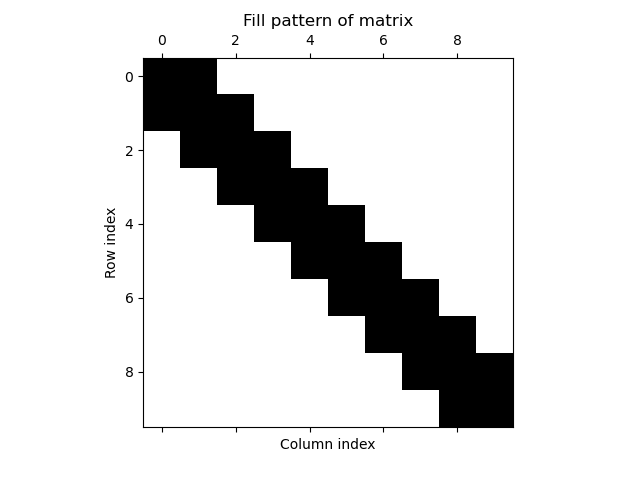

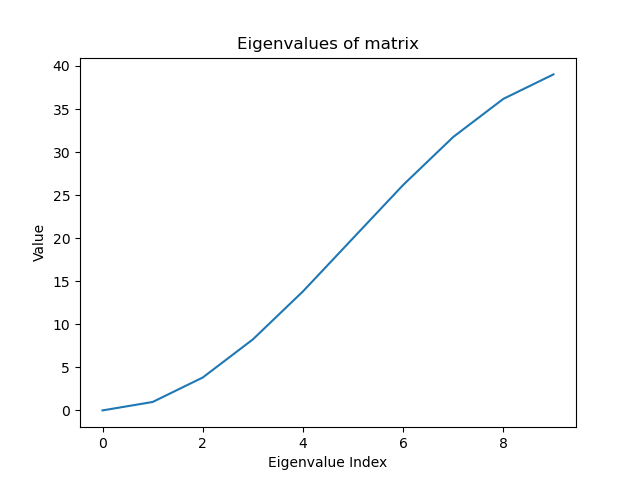

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(K);
ax.set_title('Fill pattern of matrix');
ax.set_ylabel('Row index');
ax.set_xlabel('Column index');
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
d, _ = np.linalg.eig(K)
plt.plot(np.sort( d ) );
ax.set_title('Eigenvalues of matrix');
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Value');
plt.show()

After we have verified the assembly was done correctly we can apply boundary conditions. After we have added the boundary conditions we have reduced the number of variables to solve for.

In [24]:
a = 1;
b = 2;

indices = np.array([0, N-1],dtype=np.int)
values  = np.array([a, b],dtype=np.float64)

F = np.setdiff1d(np.arange(N), indices)

for i in range(len(indices)):
    index = indices[i]
    value = values[i]  
    f[index] = value
    K[index,:] = 0.0
    K[index,index] = 1.0
    
    # TODO - Implement modifications for adding boundary conditions

for i in range(len(f)):
    if i != 0 and i != len(f)-1:
        f[i] -= a * K[i,0]
        f[i] -= b * K[i,len(f)-1]
y = np.zeros(f.shape, dtype=np.float64)

y[indices] = values

KFF = K[F,:][:,F]
fF  = f[F]

y[F] = np.linalg.solve(KFF, fF)

/var/folders/76/m4ks_3rs08bb4jc5gt400t640000gp/T/ipykernel_14470/4101763817.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.array([0, N-1],dtype=np.int)


We can now plot the solution. We expect a straight line going from a-value to b-value.

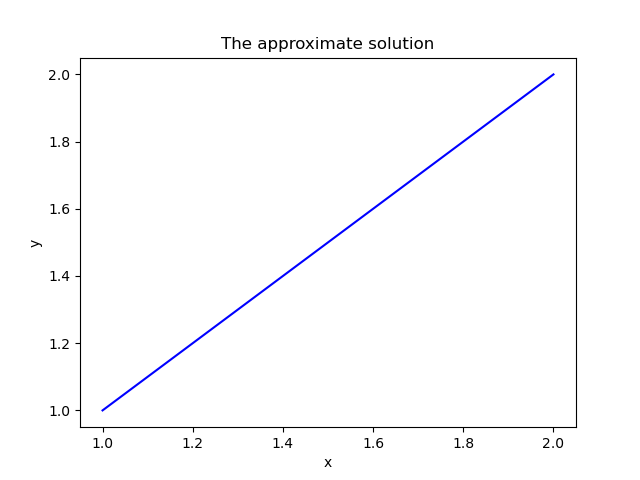

In [25]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(x,y,'b')
ax.set_title('The approximate solution')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# The 2D Poisson Problem solved with linear Finite Element Method
The 2D Poisson problem procedes in nearly the same way excpet that having both x and y coordinates increases the dimensionality slightly.

We will reuse the beam mesh generator from week 3 to create a computational mesh for the 2D problem

In [26]:
def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

number = 6
V, T = make_beam_mesh(6.0,2.0,(2*number,1*number))

We will extend with a little auxiliary function that computes the triangle area for each triangle and return a vector with all triangle area values.

In [27]:
def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A

A = compute_triangle_areas(V,T)

We now have all pieces in place and can start on compute the local element values followed by our assembly process.

In [28]:
N = len(V) # Total number of nodes in the mesh
E = len(T) # Total number of triangles in the mesh

Ke = np.zeros((3,E*3),dtype=np.float64)
K  = np.zeros((N,N),dtype=np.float64) 
f  = np.zeros((N,),dtype=np.float64) 

for e in range(E):
    # Get triangle indices
    i = T[e,0]
    j = T[e,1]
    k = T[e,2]
    # Get triangle coordinates
    xi = V[i,0]
    xj = V[j,0]
    xk = V[k,0]
    yi = V[i,1]
    yj = V[j,1]
    yk = V[k,1]    
    
    # TODO - Compute element matrix and store it in Ke array
    tempA = A[e]
    dN_dx = np.array([(yk - yj), (yi - yk), (yj-yi)])/2
    dN_dy = np.array([(xk - xj), (xi - xk), (xj-xi)])/2

    Ke[ :, (3*e):3*e+3 ] = (np.outer(dN_dx, dN_dx) + np.outer(dN_dy, dN_dy))
    # Ke[ :, (3*e):3*e+3 ] = (np.outer(dN_dx, dN_dx))


for e in range(E):
    # Get global triangle vertex indices
    i = T[e,0]
    j = T[e,1]
    k = T[e,2]
    # Local order of vertex coordinates is i j and k. 
    # This is how local vertex indices (0,1,2) are mapped to global vertex
    # indices
    gidx = [ i, j,  k]
    for ii in range(3):
        for jj in range(3):
            K[gidx[ii],gidx[jj]] += Ke[ii,3*e+jj]
    


We visually verify the assembly process by observing the expected symmetry pattern. The eigenvalue analysis should this time show that we have 2 zero eigenvalues.

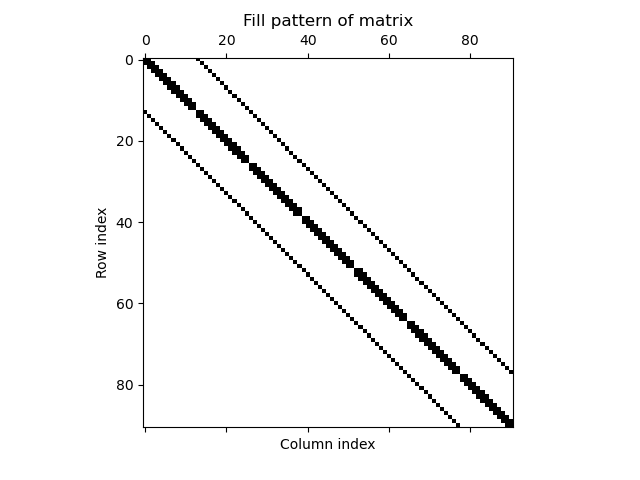

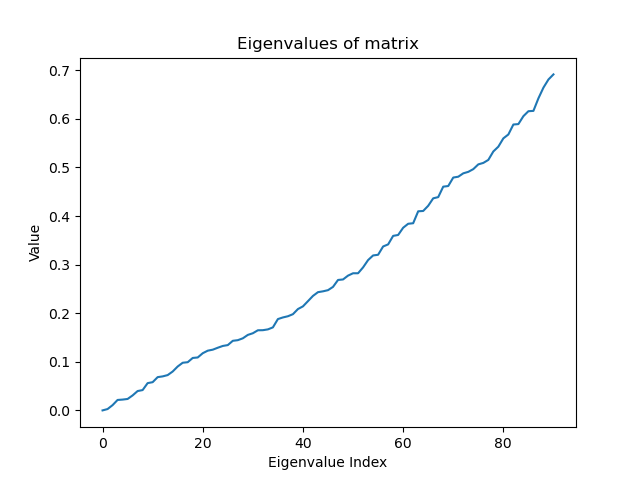

In [39]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(K);
ax.set_title('Fill pattern of matrix');
ax.set_ylabel('Row index');
ax.set_xlabel('Column index');
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
d, _ = np.linalg.eig(K)
plt.plot(np.sort( d ) );
ax.set_title('Eigenvalues of matrix');
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Value');
plt.show()

We may now proceed as before adding boundary conditions

In [30]:
a = 3;
b = 2;

left = np.array(np.where(V[:,0] < -2.9), dtype=np.int).flatten()
right = np.array(np.where(V[:,0] >  2.9), dtype=np.int).flatten()

left_values = np.ones( left.shape, dtype=np.float64)*a
right_values = np.ones( right.shape, dtype=np.float64)*b

# left_values = np.array([V[p][1]**2 for p in left])
#left_values = np.array([9,4,1,0,1,4,9])
# right_values = np.array([V[p][1]**2 for p in right])
#right_values = np.array([9,4,1,0,1,4,9])

indices = np.hstack((left, right))
values  = np.hstack((left_values, right_values))

F = np.setdiff1d(np.arange(N), indices)

f_copy = f.copy()
K_copy = K.copy()

for i in range(len(indices)):
    index = indices[i]
    value = values[i]  
  
    f_copy[index] = values[i]
    K_copy[left, :] = 0.0
    K_copy[left, left] = 1.0
    K_copy[right, :] = 0.0
    K_copy[right, right] = 1.0
    for j in range(len(f)):
        if (j != 0) and (j != len(f) - 1):
            f_copy[j] -= value * K_copy[j, index]

y = np.zeros(f_copy.shape, dtype=np.float64)

y[indices] = values

KFF = K_copy[F,:][:,F]
fF  = f_copy[F]

y[F] = np.linalg.solve(KFF, fF)

/var/folders/76/m4ks_3rs08bb4jc5gt400t640000gp/T/ipykernel_14470/4113263383.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  left = np.array(np.where(V[:,0] < -2.9), dtype=np.int).flatten()
/var/folders/76/m4ks_3rs08bb4jc5gt400t640000gp/T/ipykernel_14470/4113263383.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If 

Finally we can visualize the solution that should show a linear ramp from a to b.

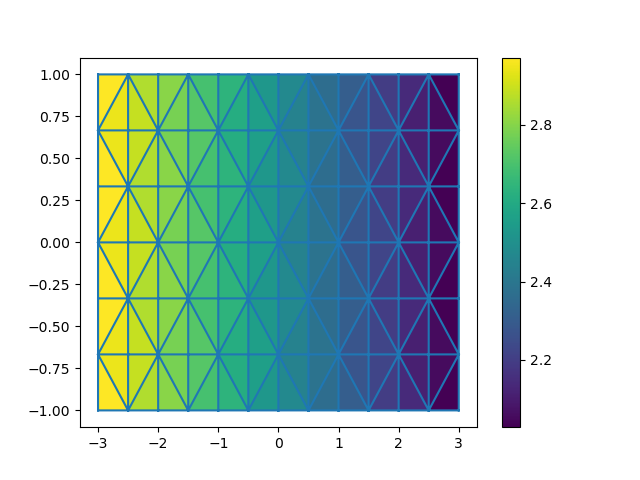

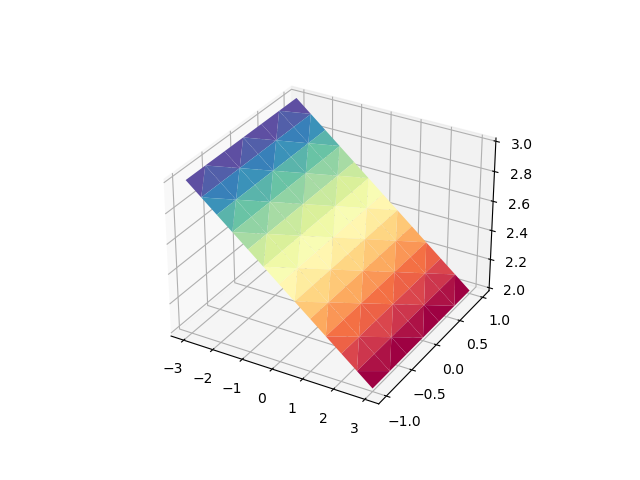

In [31]:
fig = plt.figure()

plt.tripcolor(V[:,0],V[:,1],T,y)
plt.triplot(V[:,0],V[:,1],T)
plt.colorbar()
plt.show()
# visulize the solution in 3D
fig,ax = plt.subplots(1,1,subplot_kw={'projection':'3d'})
ax.plot_trisurf(V[:,0],V[:,1],y, triangles=T, cmap=plt.cm.Spectral)
plt.show()

# get all point's coordinates
x = V[:,0]
y = V[:,1]
z = y

In [32]:
np.save('y6.npy', y)
np.save('T6.npy', T)

In [33]:
print(V.shape)
print(V)
np.save('V6.npy', V)

(91, 2)
[[-3.         -1.        ]
 [-2.5        -1.        ]
 [-2.         -1.        ]
 [-1.5        -1.        ]
 [-1.         -1.        ]
 [-0.5        -1.        ]
 [ 0.         -1.        ]
 [ 0.5        -1.        ]
 [ 1.         -1.        ]
 [ 1.5        -1.        ]
 [ 2.         -1.        ]
 [ 2.5        -1.        ]
 [ 3.         -1.        ]
 [-3.         -0.66666667]
 [-2.5        -0.66666667]
 [-2.         -0.66666667]
 [-1.5        -0.66666667]
 [-1.         -0.66666667]
 [-0.5        -0.66666667]
 [ 0.         -0.66666667]
 [ 0.5        -0.66666667]
 [ 1.         -0.66666667]
 [ 1.5        -0.66666667]
 [ 2.         -0.66666667]
 [ 2.5        -0.66666667]
 [ 3.         -0.66666667]
 [-3.         -0.33333333]
 [-2.5        -0.33333333]
 [-2.         -0.33333333]
 [-1.5        -0.33333333]
 [-1.         -0.33333333]
 [-0.5        -0.33333333]
 [ 0.         -0.33333333]
 [ 0.5        -0.33333333]
 [ 1.         -0.33333333]
 [ 1.5        -0.33333333]
 [ 2.         -0.333

In [34]:
# V10 = np.load('V10.npy')
# V30 = np.load('V30.npy')
# V50 = np.load('V50.npy')
# print(V10.shape)
# print(V30.shape)
# print(V50.shape)
# # get all points with same x coordinate
# def compute_diff(v1,v2):
#     samepoints = []
#     for i in range(len(v1)):
#         for j in range(len(v2)):
#             if v1[i][0] == v2[j][0]:
#                 samepoints.append(v1[i])
#     diffsum = 0
#     for i in range(len(samepoints)):
#         diffsum += abs(samepoints[i][1] - samepoints[i][0])
#     return diffsum/len(samepoints)
# print(compute_diff(V10,V50))
# print(compute_diff(V30,V50))



In [35]:
# import numpy as np

# # Generate sample points on V and save to file
# num_samples = min(1000, len(V))  # Set the number of samples to be at most the length of V
# plot1_samples = V[np.random.choice(len(V), num_samples, replace=False)]
# np.save('plot25_samples.npy', plot1_samples)


In [36]:
# np.save('v30.npy', V)

In [37]:
# v30 = np.load('v30.npy')
# v50 = np.load('v50.npy')
# print(len(v30))
# print(len(v50))
# assert len(v30) == len(v50) , "The number of vertices in the two meshes must be the same"
# total_distance = np.sum(np.linalg.norm(v30-v50,axis=1))
# print("The total distance between the two meshes is: ", total_distance)

In [38]:
# from scipy.spatial.distance import cdist

# sample8 = np.load('plot8_samples.npy')
# sample10 = np.load('plot10_samples.npy')
# sample15 = np.load('plot15_samples.npy')
# sample20 = np.load('plot20_samples.npy')
# sample25 = np.load('plot25_samples.npy')
# sample30 = np.load('plot30_samples.npy')
# sample50 = np.load('plot50_samples.npy')
# samples = [sample8, sample10, sample15, sample20, sample25, sample30]
# distances = []
# for i in range(len(samples)):
#     distance = (cdist(samples[i], sample50))
#     distances.append(np.max(distance))

# fig = plt.figure()
# ax = plt.subplot(111)
# plt.plot([8, 10, 15, 20, 25, 30], distances)
# ax.set_title('Hausdorff distance between sample points')
# ax.set_xlabel('Number of sample points')
# ax.set_ylabel('Hausdorff distance')
# plt.show()


That is all folks